In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, Math, Latex, HTML
from ipywidgets import interact, IntSlider, interactive
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Title
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import gridplot, row

from visualization import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(0)
tf.set_random_seed(0)

output_notebook()

Loading BokehJS ...

## Data

In [2]:
mnist = read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
n_samples = mnist.train.num_examples
print ('number of sumples:', n_samples)

number of sumples: 55000


## some model utils

In [4]:
# feed_forward model structure
from keras.layers import Input, Dense
from keras.models import Sequential, Model

def feed_forward(input_dim, layers):
    """
    Return a keras model object.
    input_dim: the orginial input dims
    layers: a list specifying the dims of each layer
    """
    model = Sequential()
    for i in range(len(layers)):
        if i == 0:
            model.add(Dense(layers[i], input_shape=(input_dim,), activation='relu'))
        else:
            model.add(Dense(layers[i], activation='relu'))
    return model

Using TensorFlow backend.


## VAE

In [5]:
from tensorflow.contrib.distributions import Normal, Bernoulli

class VAE(object):
    def __init__(self, batch_size, input_dim, latent_dim, lr=0.001):
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.lr = lr
        self._initialize()

    def _initialize(self):
        # placeholder for input data
        self.x = tf.placeholder(tf.float32, [None, self.input_dim])
        # create network
        self.create_network()
        self.obj_fun()
        # init tensorflow graph
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def create_network(self):
        self.z_mean, self.z_log_std = self.encoder_network(self.x)
        self.z = self.sampling(self.z_mean, self.z_log_std)
        self.x_decoded = self.decoder_network(self.z)

    def encoder_network(self, x):
        """
        Takes in x, and return parameters of latents z.
        """
        # two intermediate layer
        layers = [32, 32]
        h = feed_forward(self.input_dim, layers)(x)
        z_mean = Dense(self.latent_dim)(h)
        z_log_std = Dense(self.latent_dim)(h)
        return z_mean, z_log_std

    def sampling(self, z_mean, z_log_std):
        """
        Takes in the parameters for z, and return samples.
        """
        epsilon = tf.random_normal(shape=(batch_size, latent_dim), mean=0.,
                                   stddev=1.0)
        z = z_mean + tf.exp(z_log_std) * epsilon
        return z

    def decoder_network(self, z):
        """
        Take latents, and return reconstruction.
        """
        layers = [32, 32]
        h = feed_forward(self.latent_dim, layers)(z)
        x_recon = Dense(self.input_dim, activation='sigmoid')(h)
        x_recon = tf.clip_by_value(x_recon, 0.000001, 0.999999)
        return x_recon

    def obj_fun(self):
        """
        calculate ELBO
        """
        log_px_gz = tf.reduce_sum(Bernoulli(probs=self.x_decoded).log_prob(self.x), axis=1)
        log_p_z = tf.reduce_sum(Normal(0.0, 1.0).log_prob(self.z), axis=1)
        log_q_z_gx = tf.reduce_sum(Normal(self.z_mean, tf.exp(self.z_log_std)).log_prob(self.z), axis=1)
        self.obj = tf.reduce_sum(log_px_gz + log_p_z - log_q_z_gx) / self.batch_size
        self.opt = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(-self.obj)

    def minbatch_fit(self, X):
        opt, obj = self.sess.run((self.opt, self.obj), feed_dict={self.x: X})
        return obj

    def latent_space_visulization(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def recons(self, X):
        return self.sess.run(self.x_decoded, feed_dict={self.x: X})

    def generating_samples(self, z_mu):
        return self.sess.run(self.x_decoded, feed_dict={self.z: z_mu})

In [6]:
batch_size=100
input_dim = 784
latent_dim = 2
lr = 0.001

vae_model = VAE(batch_size, input_dim, latent_dim, lr)

## Training

In [7]:
training_epochs=30
printing = 1

In [8]:
x_sample_m, y_labels_m = mnist.test.next_batch(5000)
cost_plotting=[]
laten_space=[]
reconstructed=[]
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        cost = vae_model.minbatch_fit(batch_xs)
        avg_cost += cost / n_samples * batch_size
        
    if epoch % printing == 0:
        cost_plotting.append(avg_cost)
        laten_space.append(vae_model.latent_space_visulization(x_sample_m))
        reconstructed.append(vae_model.recons(x_sample_m[:100]))
        print("Epoch:", '%02d' % (epoch+1), "ELBO =", "{:.9f}".format(avg_cost))

Epoch: 01 ELBO = -224.647295810
Epoch: 02 ELBO = -184.553701505
Epoch: 03 ELBO = -177.157721835
Epoch: 04 ELBO = -172.912083934
Epoch: 05 ELBO = -169.539027377
Epoch: 06 ELBO = -167.753414334
Epoch: 07 ELBO = -166.409933499
Epoch: 08 ELBO = -165.104075345
Epoch: 09 ELBO = -163.847943282
Epoch: 10 ELBO = -162.565257291
Epoch: 11 ELBO = -161.288613503
Epoch: 12 ELBO = -160.213608537
Epoch: 13 ELBO = -159.337461576
Epoch: 14 ELBO = -158.546049305
Epoch: 15 ELBO = -157.914539462
Epoch: 16 ELBO = -157.358234253
Epoch: 17 ELBO = -156.937578014
Epoch: 18 ELBO = -156.666049194
Epoch: 19 ELBO = -156.177640769
Epoch: 20 ELBO = -155.832383700
Epoch: 21 ELBO = -155.446301519
Epoch: 22 ELBO = -155.200919356
Epoch: 23 ELBO = -154.868842163
Epoch: 24 ELBO = -154.597887767
Epoch: 25 ELBO = -154.364095542
Epoch: 26 ELBO = -153.983223905
Epoch: 27 ELBO = -153.848394526
Epoch: 28 ELBO = -153.462263184
Epoch: 29 ELBO = -153.302778709
Epoch: 30 ELBO = -153.047667902


## Let's look at the results.

In [9]:
visu=Visualization(total_epoch=training_epochs, batch_size=batch_size, printing=printing)

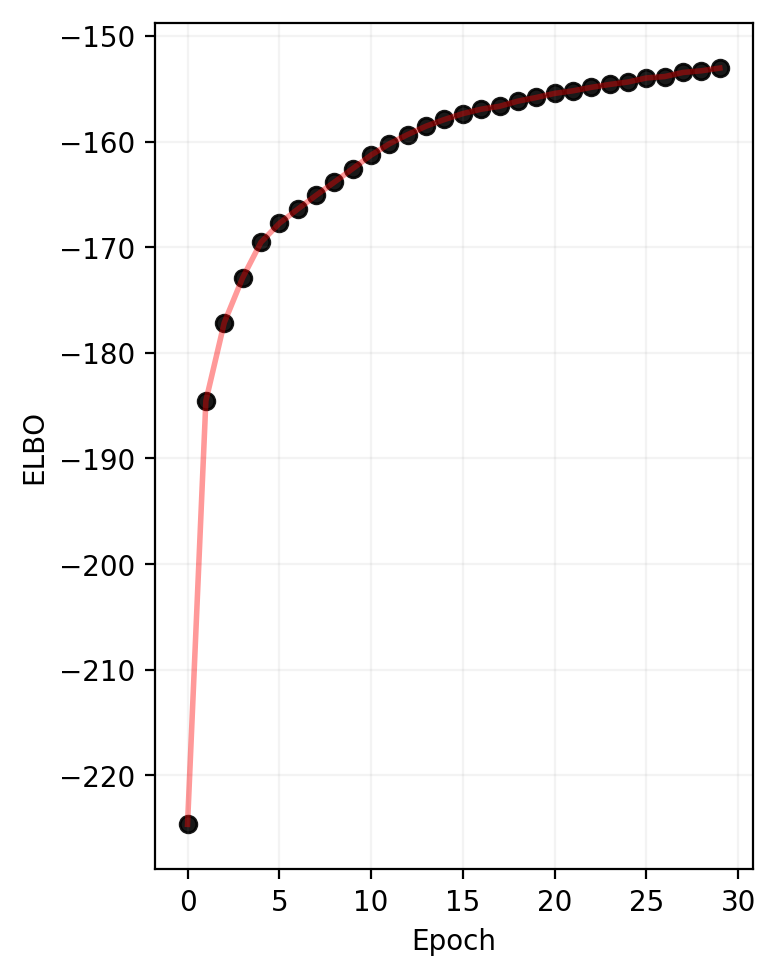

In [10]:
#train cost
visu.plotting_cost(cost_plotting)

In [14]:
#latens space visualization our training
visu.plotting_latent_space(laten_space, y_labels_m)

In [17]:
# reconstruction visualization
visu.plotting_training_visual(reconstructed, x_sample_m[:100])

(30, 100, 28, 28)
(100, 28, 28)


Loading BokehJS ...

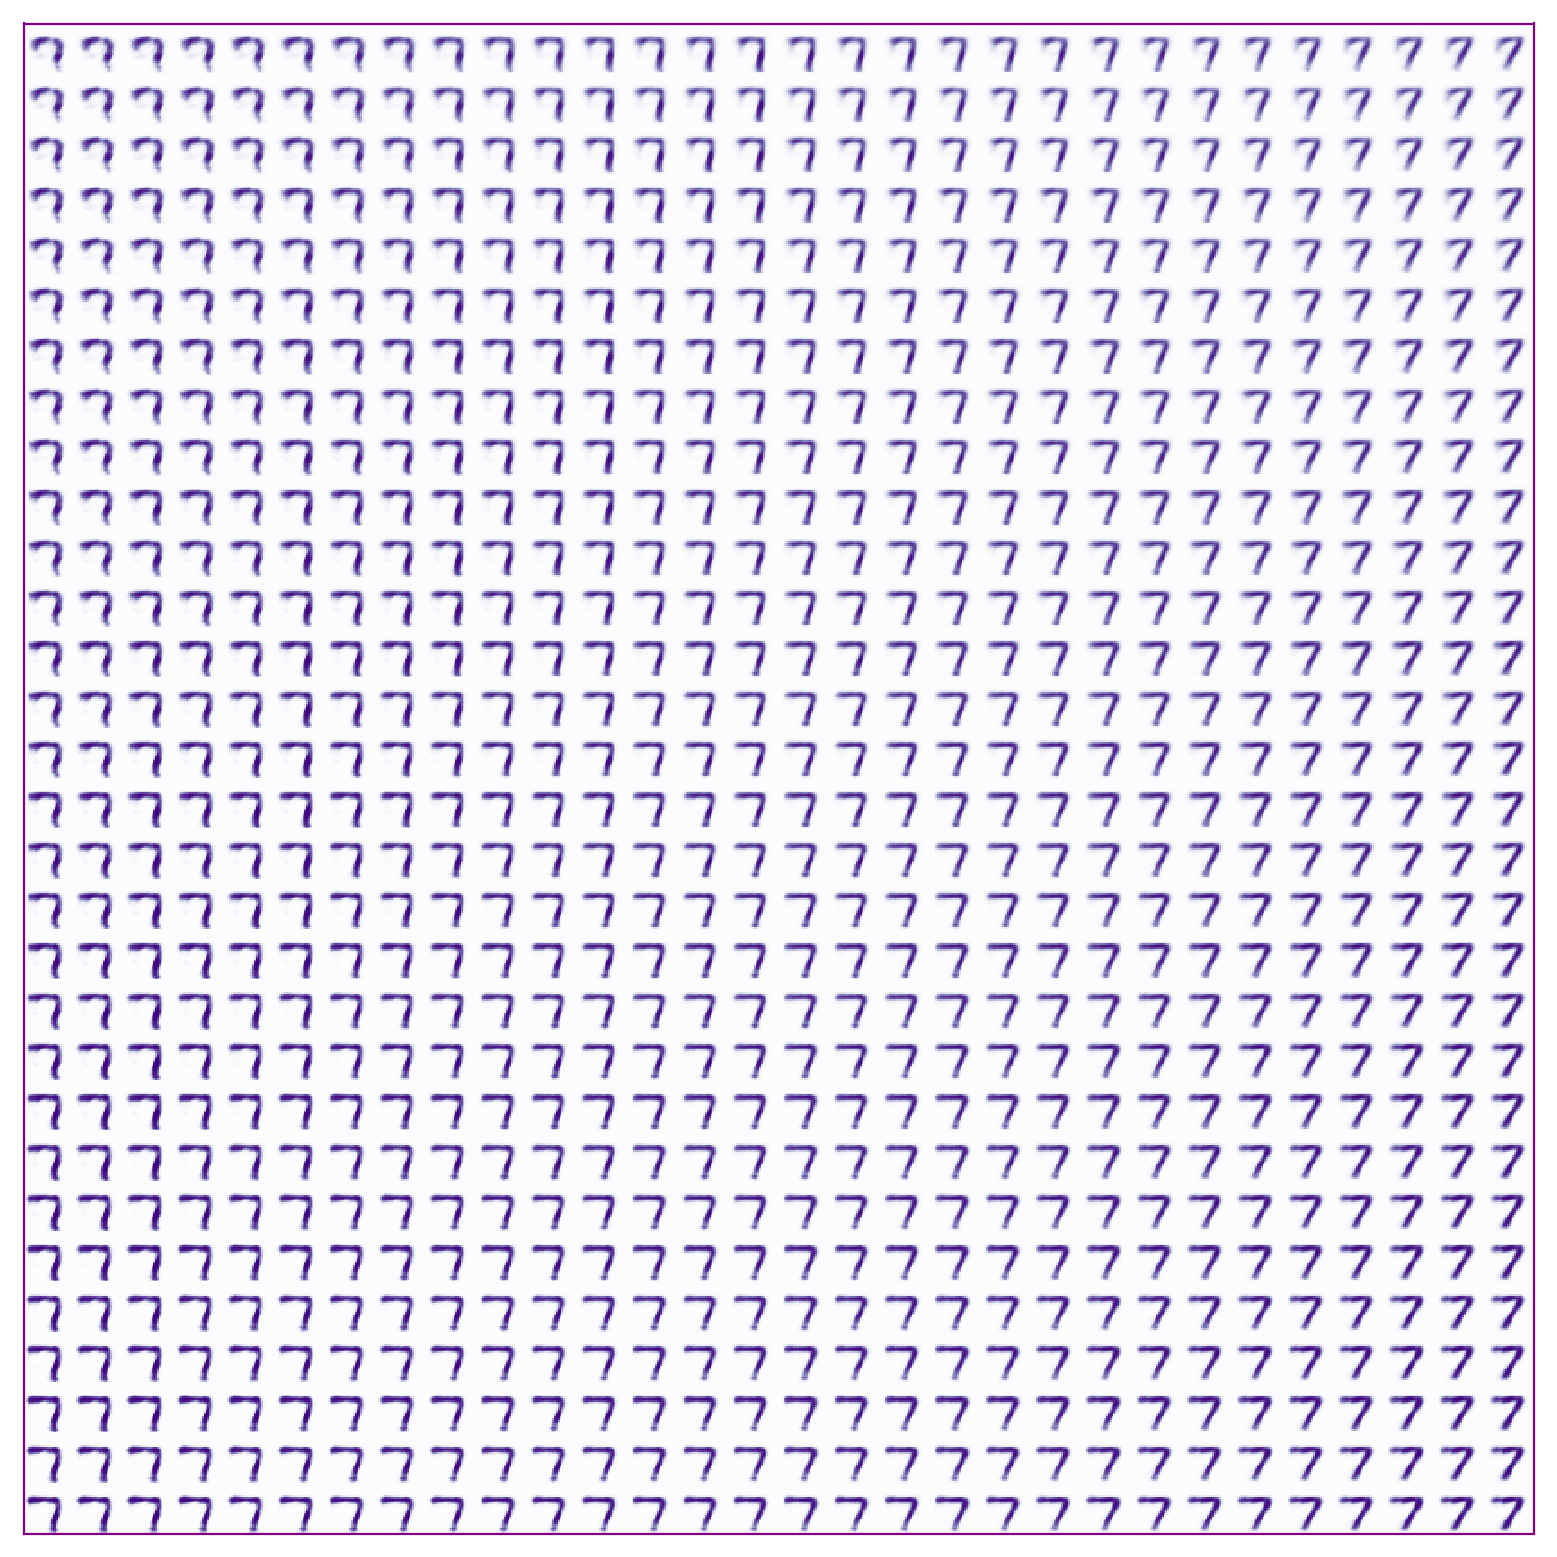

In [19]:
#generation of new data using custum mean
visu.plott_gener_sample_from_dist(vae_model, -4, -2, 0, 2)